<a href="https://colab.research.google.com/github/ThaiiFenelon/CharalambosIoannou/blob/master/Americanas_VAI_Case__A_Tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
## import holidays
import datetime as dt
from datetime import timedelta
import itertools
import time
import sqlalchemy
import pyarrow
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score)
from sklearn.model_selection import (GridSearchCV, TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use("ggplot")

pd.set_option("display.max_rows", 200)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm

In [ ]:
#configuração da exibição dos gráficos
import matplotlib.font_manager
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12
plt.style.use("ggplot")
teal = "#00c0d2"
light_blue = "#4251bc"
blue = "#262e6c"
dark_blue = "#111530"
black = "#000000"
cian = "#4aa6ee"

In [ ]:
!pip install --upgrade xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 32 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Aquisição e Preparação dos Dados

In [ ]:
#path = ""
path = '/content/drive/MyDrive/Cursos/Capacitação/'

## Lojas

In [ ]:
df_lojas = pd.read_csv(path + 'lojas.csv')

In [ ]:
df_lojas.head()

,loja,tipo_de_loja,tamanho
0,1,A,97.622581
1,2,A,130.520645
2,3,B,24.123871
3,4,A,132.814839
4,5,B,22.500000


In [ ]:
df_lojas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loja          45 non-null     int64  
 1   tipo_de_loja  45 non-null     object 
 2   tamanho       45 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [ ]:
df_lojas.describe()

,loja,tamanho
count,45.000000,45.000000
mean,23.000000,84.056516
std,13.133926,41.177595
min,1.000000,22.500000
25%,12.000000,45.621290
50%,23.000000,81.620645
75%,34.000000,130.520645
max,45.000000,141.691613


In [ ]:
df_lojas.shape[0] - df_lojas.drop_duplicates().shape[0] #não tem valores duplicados

0

In [ ]:
df_lojas.isna().sum() # não tem valores vazios

loja            0
tipo_de_loja    0
tamanho         0
dtype: int64

## Características

In [ ]:
df_caracteristicas = pd.read_csv(path + 'outras_variaveis.csv')

In [ ]:
df_caracteristicas.head()

,loja,data,preco_combustivel,IPC,taxa_desemprego,evento
0,1,2010-02-05,2.572,211.096358,8.106,False
1,1,2010-02-12,2.548,211.242170,8.106,True
2,1,2010-02-19,2.514,211.289143,8.106,False
3,1,2010-02-26,2.561,211.319643,8.106,False
4,1,2010-03-05,2.625,211.350143,8.106,False


In [ ]:
df_caracteristicas['data'] = pd.to_datetime(df_caracteristicas.data, infer_datetime_format=True)

In [ ]:
df_caracteristicas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   loja               8190 non-null   int64         
 1   data               8190 non-null   datetime64[ns]
 2   preco_combustivel  8190 non-null   float64       
 3   IPC                7605 non-null   float64       
 4   taxa_desemprego    7605 non-null   float64       
 5   evento             8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 328.0 KB


In [ ]:
df_caracteristicas.describe()

,loja,preco_combustivel,IPC,taxa_desemprego
count,8190.000000,8190.000000,7605.000000,7605.000000
mean,23.000000,3.405992,172.460809,7.826821
std,12.987966,0.431337,39.738346,1.877259
min,1.000000,2.472000,126.064000,3.684000
25%,12.000000,3.041000,132.364839,6.634000
50%,23.000000,3.513000,182.764003,7.806000
75%,34.000000,3.743000,213.932412,8.567000
max,45.000000,4.468000,228.976456,14.313000


In [ ]:
df_caracteristicas.shape[0] - df_caracteristicas.drop_duplicates().shape[0] #não tem valores duplicados

0

In [ ]:
df_lojas.isna().sum() # não tem valores vazios

loja            0
tipo_de_loja    0
tamanho         0
dtype: int64

## Vendas

In [ ]:
df_vendas = pd.read_csv(path + 'vendas.csv')

In [ ]:
df_vendas.head()

,loja,departamento,data,venda_semanal,semana_de_evento
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [ ]:
df_vendas['data'] = pd.to_datetime(df_vendas.data, infer_datetime_format=True)

In [ ]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   loja              421570 non-null  int64         
 1   departamento      421570 non-null  int64         
 2   data              421570 non-null  datetime64[ns]
 3   venda_semanal     421570 non-null  float64       
 4   semana_de_evento  421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [ ]:
df_vendas.describe()

,loja,departamento,venda_semanal
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [ ]:
df_vendas.shape[0] - df_vendas.drop_duplicates().shape[0] #não tem valores duplicados

0

In [ ]:
df_vendas.isna().sum() # não tem valores vazios

loja                0
departamento        0
data                0
venda_semanal       0
semana_de_evento    0
dtype: int64

# Análise Exploratória

## Analisando Lojas

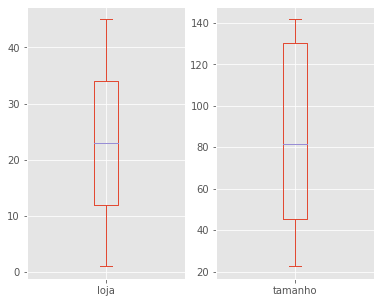

<Figure size 720x288 with 0 Axes>

In [ ]:
#sem outliers
df_lojas.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 9))
_ = plt.figure()

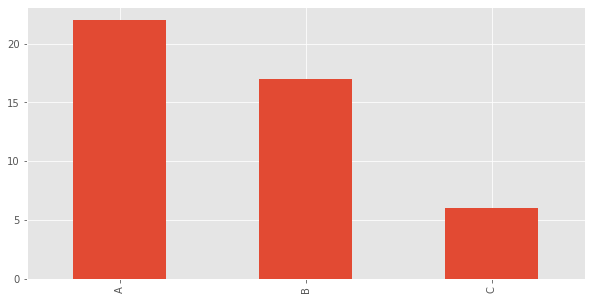

In [ ]:
#quantidades por tipo de loja
df_lojas['tipo_de_loja'].value_counts().plot(kind="bar", figsize=(10, 5), layout=(1, 8));

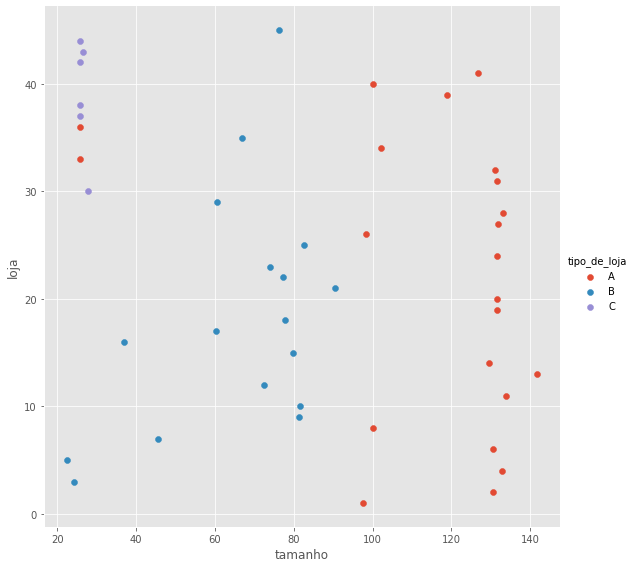

In [ ]:
#tamanho x loja (tipos)
#lojas do tipo A costumam ser maiores
#lojas do tipo C costumam ser menores
sns.FacetGrid(df_lojas, hue="tipo_de_loja", height=8) \
   .map(plt.scatter, "tamanho", "loja") \
   .add_legend()

plt.show()

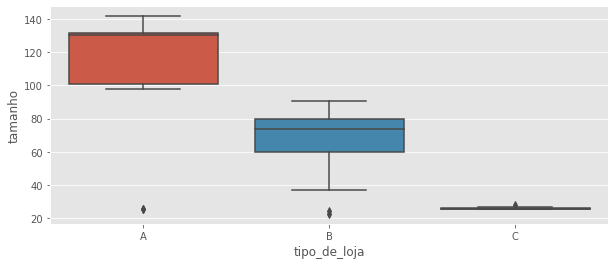

In [ ]:
#Lojas dp tipo A costumam ser maiores e do tipo C costumam ser menores
sns.boxplot(x="tipo_de_loja", y="tamanho", data=df_lojas)
plt.show()

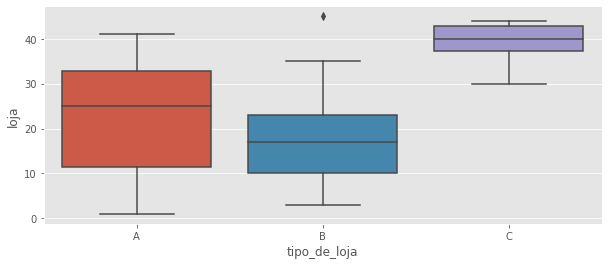

In [ ]:
#Mais lojas do tipo A e menos do tipo C
sns.boxplot(x="tipo_de_loja", y="loja", data=df_lojas)
plt.show()

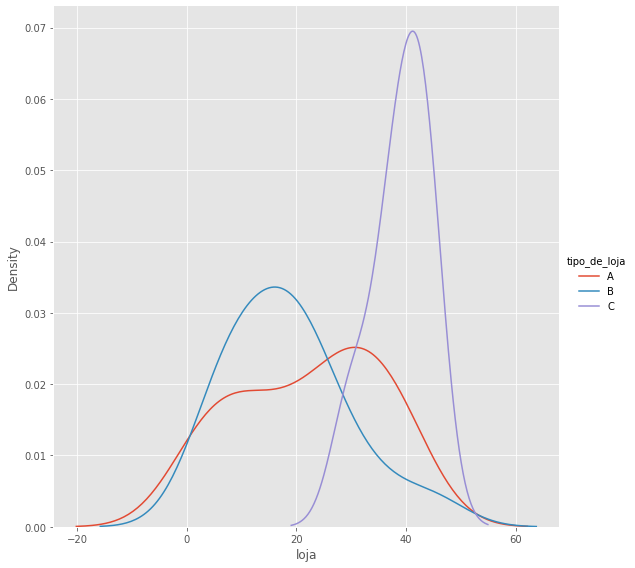

In [ ]:
#KDE (tipos de loja)
sns.FacetGrid(df_lojas, hue="tipo_de_loja", height=8).map(sns.kdeplot, "loja").add_legend()
plt.show()

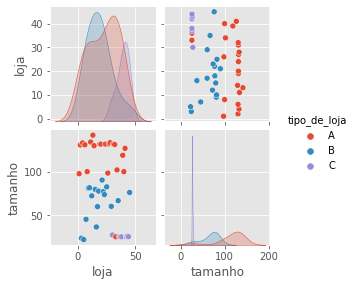

In [ ]:
_ = sns.pairplot(df_lojas, hue="tipo_de_loja", height=2, diag_kind="kde")

## Analisando Características (outras variáveis)

In [ ]:
#verificando valores nulos
df_caracteristicas.isnull().sum()

loja                   0
data                   0
preco_combustivel      0
IPC                  585
taxa_desemprego      585
evento                 0
dtype: int64

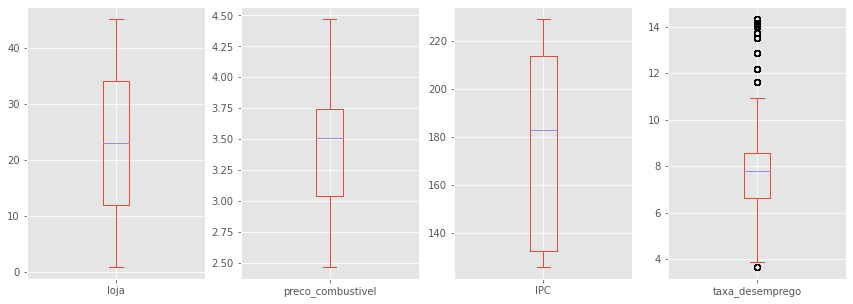

<Figure size 720x288 with 0 Axes>

In [ ]:
df_caracteristicas.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 8))
_ = plt.figure()

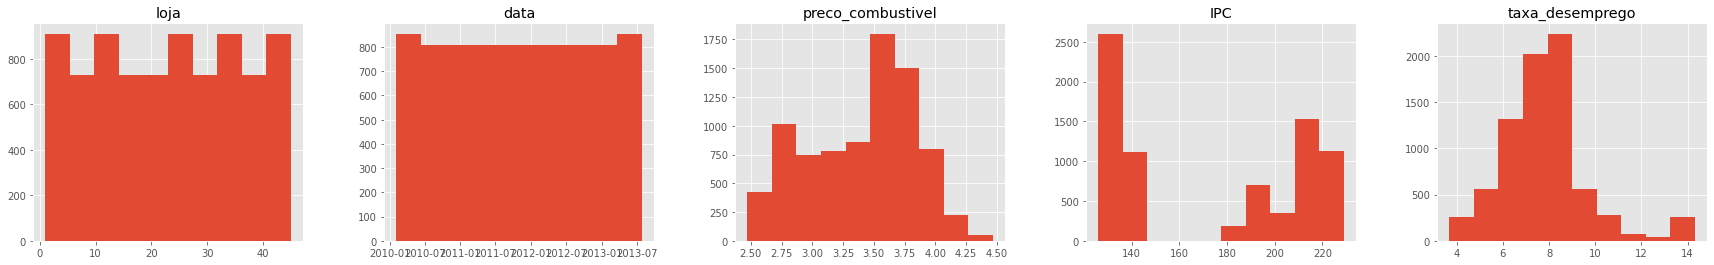

<Figure size 720x288 with 0 Axes>

In [ ]:
df_caracteristicas.hist(figsize=(30,4), layout=(1,5))
_ = plt.figure()

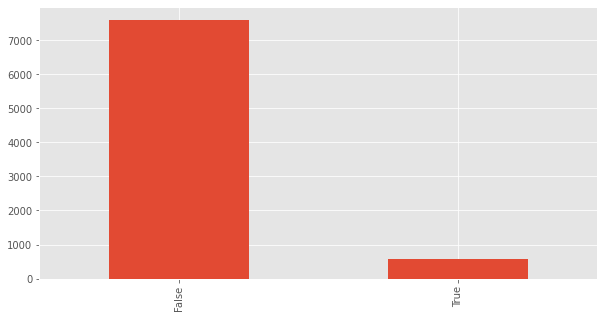

In [ ]:
#Dias de evento (proporção)
df_caracteristicas['evento'].value_counts().plot(kind="bar", figsize=(10, 5), layout=(1, 8));

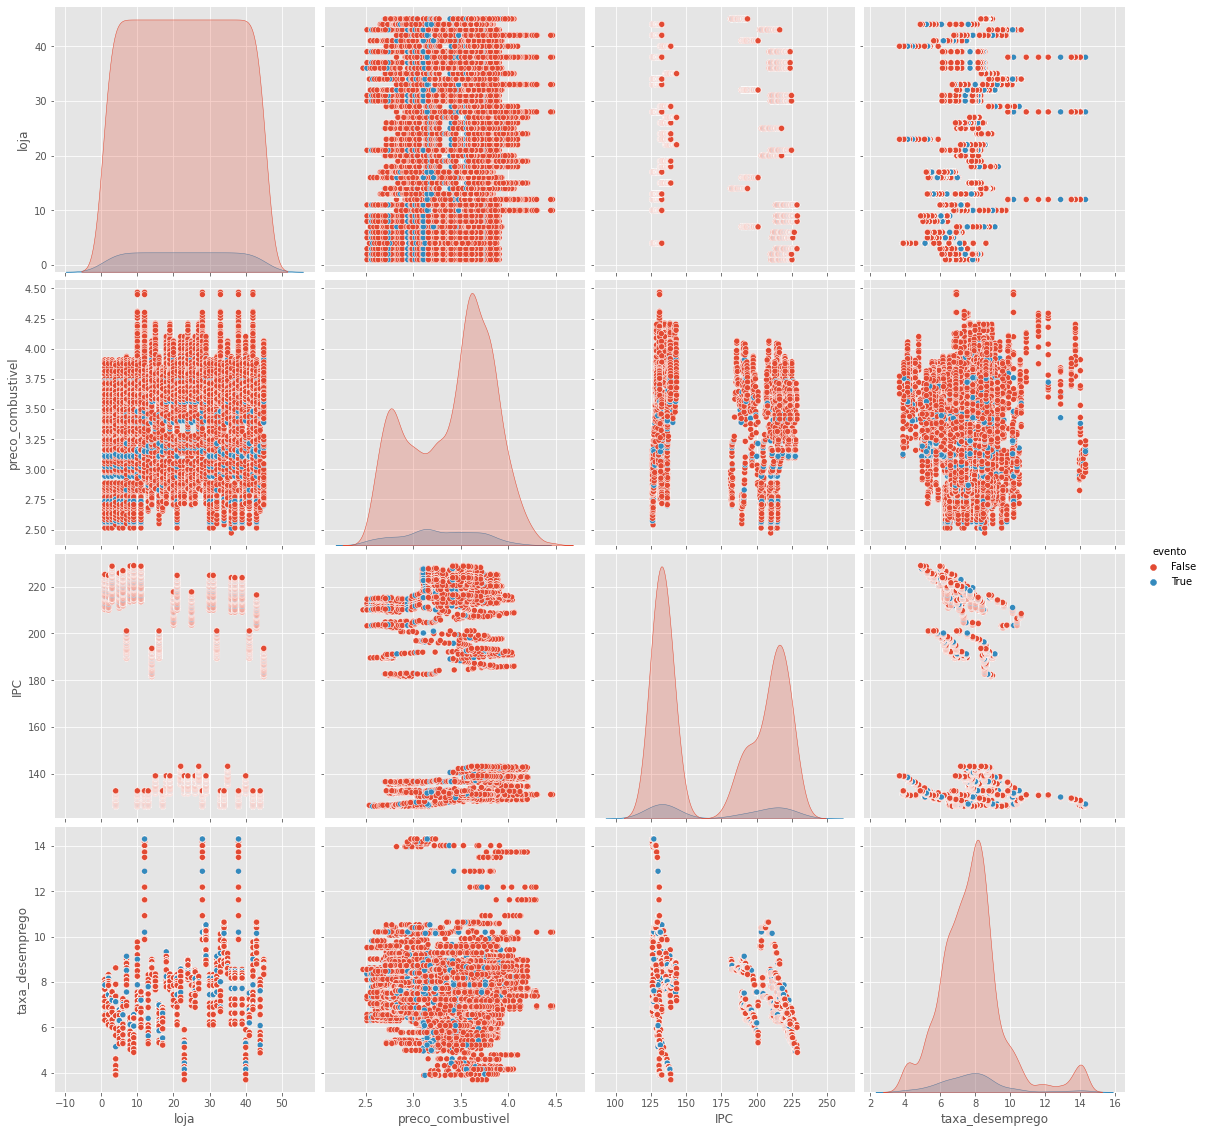

In [ ]:
_ = sns.pairplot(df_caracteristicas, hue="evento", height=4, diag_kind="kde")

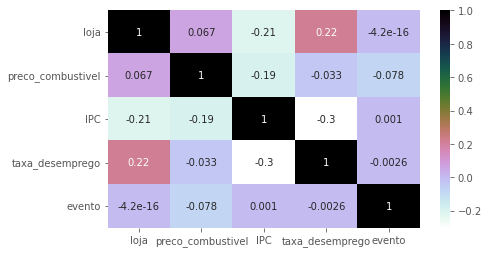

In [ ]:
#Heatmap (correlação)
plt.figure(figsize=(7,4)) 
sns.heatmap(df_caracteristicas.corr(),annot=True,cmap='cubehelix_r')

plt.show()

## Analisando Vendas

In [ ]:
df_vendas_data = df_vendas.copy()
df_vendas_data.set_index('data', inplace=True) #data como indice

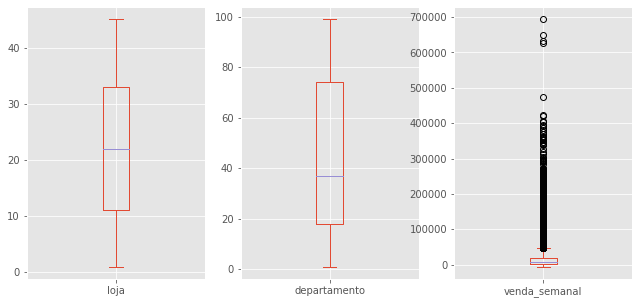

<Figure size 720x288 with 0 Axes>

In [ ]:
df_vendas.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 8))
_ = plt.figure()

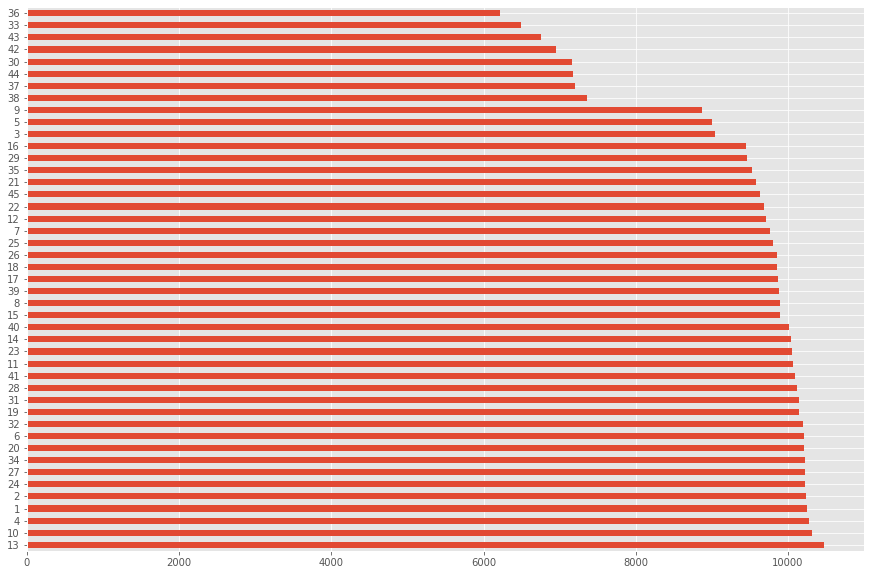

In [ ]:
#quantas linhas na planilha (semanas avaliadas) de cada loja (incluindo todos os departamentos por loja)
df_vendas['loja'].value_counts().plot(kind="barh", figsize=(15, 10), layout=(1, 8));

### Melhores vendas Individuais

In [ ]:
df_vendas.sort_values(by='venda_semanal', ascending=False).head(10) # melhores dias de vendas individuais

,loja,departamento,data,venda_semanal,semana_de_evento
95373,10,72,2010-11-26,693099.36,True
338013,35,72,2011-11-25,649770.18,True
95425,10,72,2011-11-25,630999.19,True
337961,35,72,2010-11-26,627962.93,True
135665,14,72,2010-11-26,474330.10,True
195088,20,72,2010-11-26,422306.25,True
264390,27,72,2010-11-26,420586.57,True
88428,10,7,2010-12-24,406988.63,False
95377,10,72,2010-12-24,404245.03,False
214432,22,72,2010-11-26,393705.20,True


In [ ]:
df_vendas.sort_values(by='venda_semanal', ascending=False).head(10)['data'].value_counts() #quais são os melhores dias

2010-11-26    6
2011-11-25    2
2010-12-24    2
Name: data, dtype: int64

In [ ]:
df_vendas.sort_values(by='venda_semanal', ascending=False).head(10)['loja'].value_counts() #quais são as melhores lojas nesses dias

10    4
35    2
14    1
20    1
27    1
22    1
Name: loja, dtype: int64

In [ ]:
df_vendas.sort_values(by='venda_semanal', ascending=False).head(10)['departamento'].value_counts() # quais são os melhores departamentos nesses dias

72    9
7     1
Name: departamento, dtype: int64

### Vendas por lojas

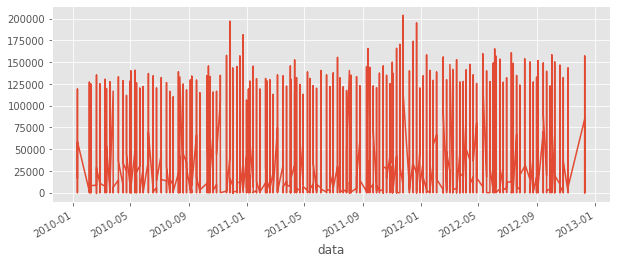

In [ ]:
#Loja 1
df_vendas_data[df_vendas_data.loja==1]['venda_semanal'].plot()

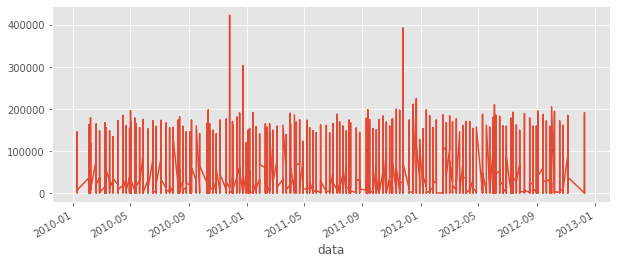

In [ ]:
#Loja 20
df_vendas_data[df_vendas_data.loja==20]['venda_semanal'].plot()

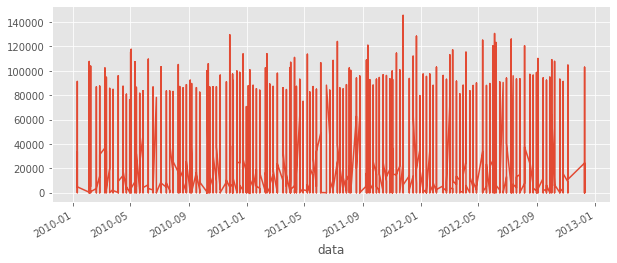

In [ ]:
#Loja 40
df_vendas_data[df_vendas_data.loja==40]['venda_semanal'].plot()

### Vendas por Departamentos

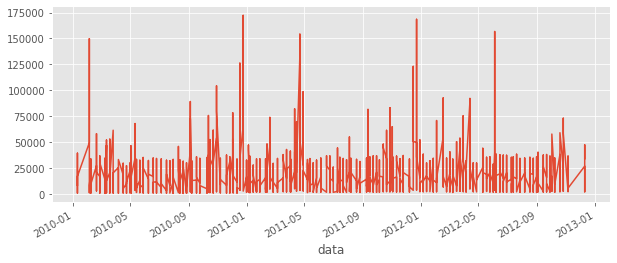

In [ ]:
#Departamento 1
df_vendas_data[df_vendas_data.departamento==1]['venda_semanal'].plot() 

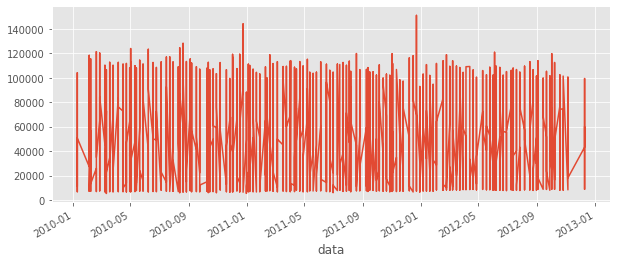

In [ ]:
#Departamento 2
df_vendas_data[df_vendas_data.departamento==2]['venda_semanal'].plot() 

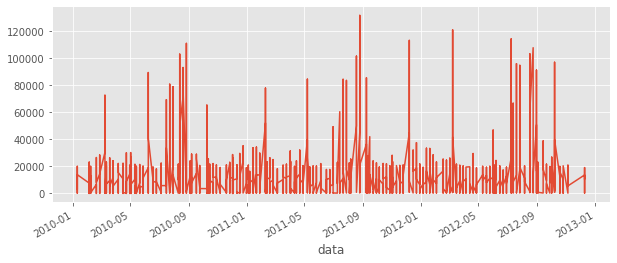

In [ ]:
#Departamento 3
df_vendas_data[df_vendas_data.departamento==3]['venda_semanal'].plot() 

### Gráficos

Vendas x Data

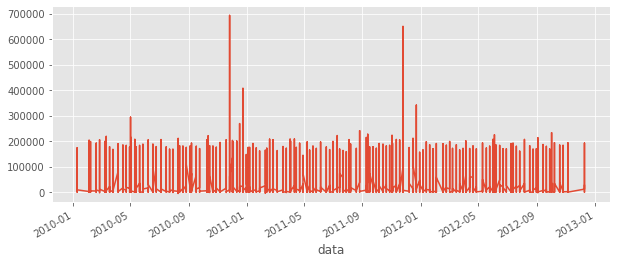

In [ ]:
df_vendas_data['venda_semanal'].plot() #plot de vendas pelas datas

Vendas x Data (lojas)


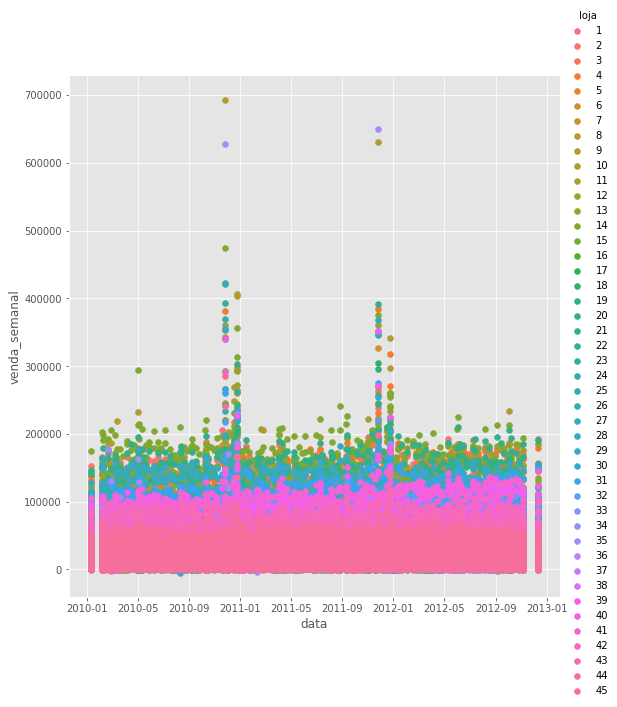

In [ ]:
sns.FacetGrid(df_vendas, hue="loja", height=8) \
   .map(plt.scatter, "data", "venda_semanal") \
   .add_legend()

plt.show()

Vendas x Data (departamentos)

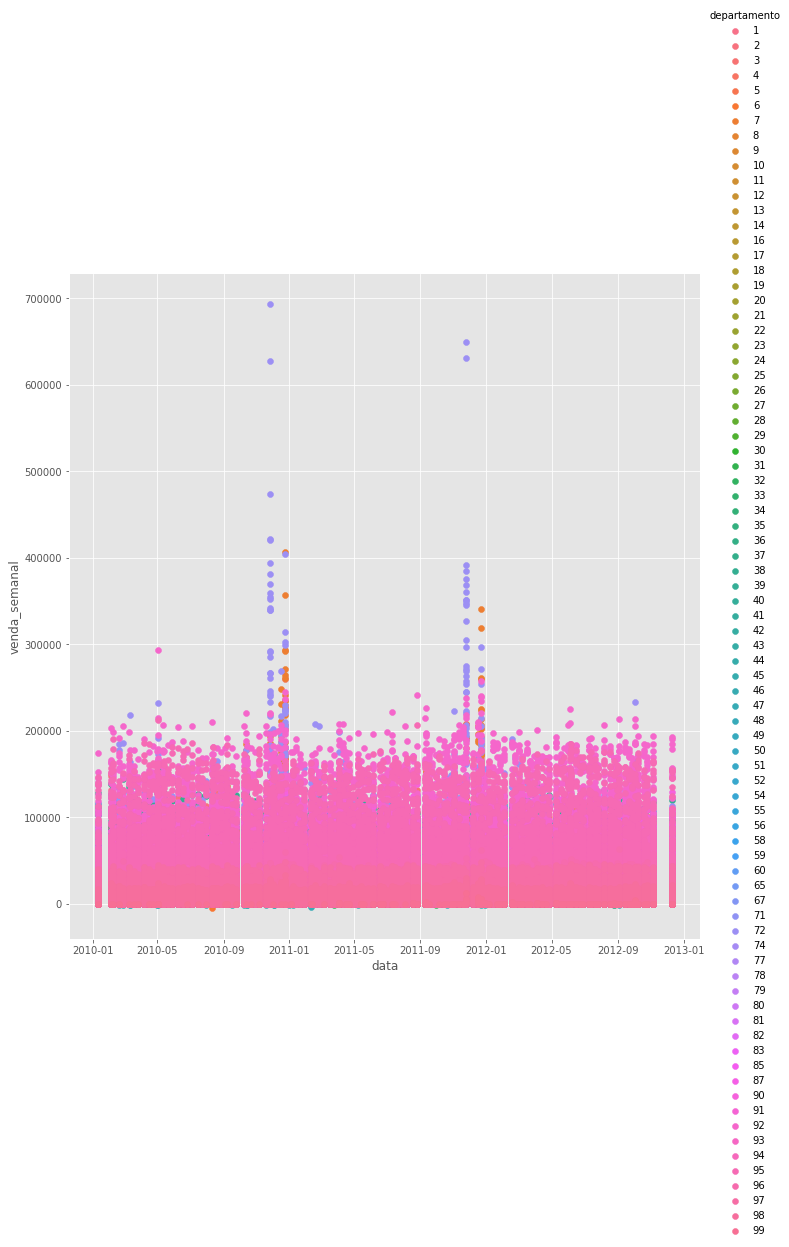

In [ ]:
sns.FacetGrid(df_vendas, hue="departamento", height=10) \
   .map(plt.scatter, "data", "venda_semanal") \
   .add_legend()

plt.show()

### Total de vendas por data

In [ ]:
df = pd.DataFrame(columns=['data', 'sum_vendas_semanas'])
df_sum = df_vendas.groupby('data').agg({"venda_semanal": "sum"})
df['data'] = list(df_sum.index.values)
df['sum_vendas_semanas'] = df_vendas.groupby('data').agg({"venda_semanal": "sum"})['venda_semanal'].to_list()
df.sort_values(by='sum_vendas_semanas', ascending=False).head(10)['data'].value_counts()

2010-12-24    1
2011-12-23    1
2011-11-25    1
2010-11-26    1
2010-12-17    1
2011-12-16    1
2010-10-12    1
2011-09-12    1
2012-06-04    1
2012-06-07    1
Name: data, dtype: int64

In [ ]:
df_vendas.groupby('departamento')['venda_semanal'].mean().nlargest(10) # melhores departamemtos em média

departamento
92    75204.870531
95    69824.423080
38    61090.619568
72    50566.515417
65    45441.706224
90    45232.084488
40    44900.702727
2     43607.020113
91    33687.910758
94    33405.883963
Name: venda_semanal, dtype: float64

In [ ]:
df_vendas.groupby('departamento')['venda_semanal'].sum().nlargest(10) # melhores departamentos na soma total

departamento
92    4.839433e+08
95    4.493202e+08
38    3.931181e+08
72    3.057252e+08
90    2.910685e+08
40    2.889360e+08
2     2.806112e+08
91    2.167817e+08
13    1.973216e+08
8     1.942808e+08
Name: venda_semanal, dtype: float64

In [ ]:
df_vendas.groupby('loja')['venda_semanal'].mean().nlargest(10) #melhores lojas em média

loja
20    29508.301592
4     29161.210415
14    28784.851727
13    27355.136891
2     26898.070031
10    26332.303819
27    24826.984536
6     21913.243624
1     21710.543621
39    21000.763562
Name: venda_semanal, dtype: float64

In [ ]:
df_vendas.groupby('loja')['venda_semanal'].sum().nlargest(10) #melhores lojas na soma total

loja
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
Name: venda_semanal, dtype: float64

### Demanda de Vendas

In [ ]:
df_vendas_demanda = df_vendas.copy()
df_vendas_demanda["Data"] = pd.to_datetime(df_vendas_demanda["data"])
df_vendas_demanda = df_vendas_demanda.drop(columns=["data"])
df_vendas_demanda["dataref"] = df_vendas_demanda["Data"].dt.strftime("%Y%m%d")
df_vendas_demanda['ano'] = df_vendas_demanda["Data"].dt.year
df_vendas_demanda['mes'] = df_vendas_demanda["Data"].dt.month
df_vendas_demanda['semana'] = df_vendas_demanda["Data"].dt.week
df_vendas_demanda['dia'] = df_vendas_demanda["Data"].dt.day
df_vendas_demanda['dia_semana'] = df_vendas_demanda["Data"].dt.dayofweek

df_vendas_demanda.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   loja              421570 non-null  int64         
 1   departamento      421570 non-null  int64         
 2   venda_semanal     421570 non-null  float64       
 3   semana_de_evento  421570 non-null  bool          
 4   Data              421570 non-null  datetime64[ns]
 5   dataref           421570 non-null  object        
 6   ano               421570 non-null  int64         
 7   mes               421570 non-null  int64         
 8   semana            421570 non-null  int64         
 9   dia               421570 non-null  int64         
 10  dia_semana        421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 32.6+ MB


In [ ]:
#meses de eventos (picos) do ano
df_vendas_eventos = df_vendas_demanda.loc[(df_vendas_demanda['mes']==2) | (df_vendas_demanda['mes']==9) | (df_vendas_demanda['mes']==11) | (df_vendas_demanda['mes']==12)]
idx_eventos = df_vendas_eventos.groupby("dataref")["venda_semanal"].idxmax()

df_vendas_demanda["meses_eventos"] = 0
df_vendas_demanda.loc[idx_eventos, "meses_eventos"] = 1

#df_vendas_demanda.set_index("Data", inplace=True)

df_vendas_demanda.head()

,loja,departamento,venda_semanal,semana_de_evento,dataref,ano,mes,semana,dia,dia_semana,meses_eventos
Data,,,,,,,,,,,
2010-05-02,1,1,24924.50,False,20100502,2010,5,17,2,6,0
2010-12-02,1,1,46039.49,True,20101202,2010,12,48,2,3,1
2010-02-19,1,1,41595.55,False,20100219,2010,2,7,19,4,1
2010-02-26,1,1,19403.54,False,20100226,2010,2,8,26,4,1
2010-05-03,1,1,21827.90,False,20100503,2010,5,18,3,0,0


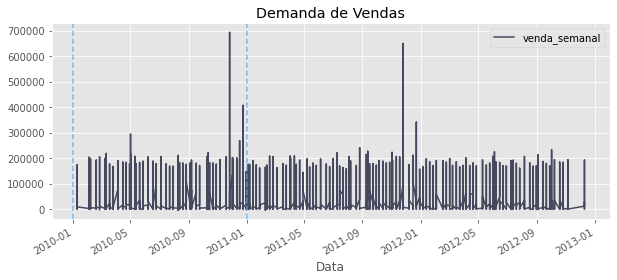

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  # This is added back by InteractiveShellApp.init_path()


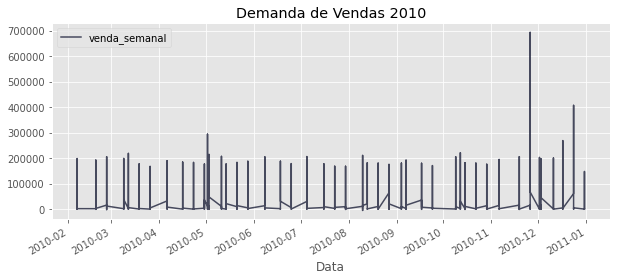

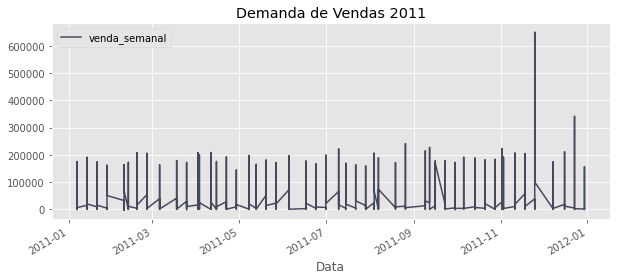

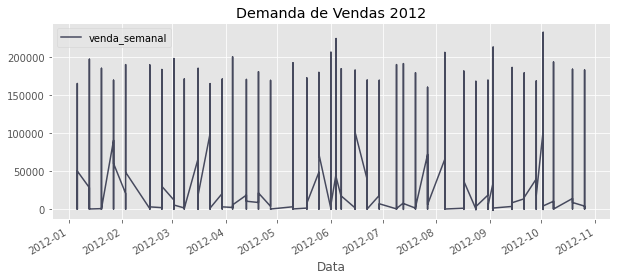

In [ ]:
#Demanda de Vendas Anual

ax = df_vendas_demanda.plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas", c=dark_blue, alpha=0.75,
)

for y in np.arange(2010, 2012):
  ax.axvline(dt.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_vendas_demanda.loc["2010-02-05":"2010-12-31"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas 2010", c=dark_blue, alpha=0.75,
)

df_vendas_demanda.loc["2011-01-07":"2011-12-30"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas 2011", c=dark_blue, alpha=0.75,
)

df_vendas_demanda.loc["2012-01-06":"2012-10-26"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas 2012", c=dark_blue, alpha=0.75,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  # Remove the CWD from sys.path while we load stuff.


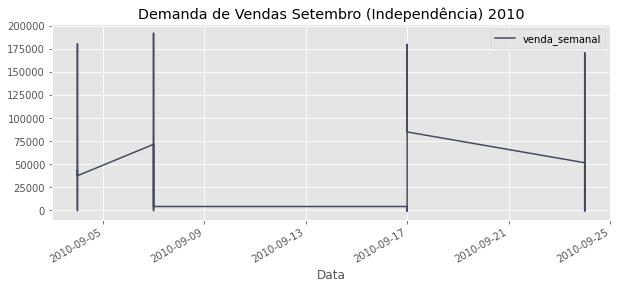

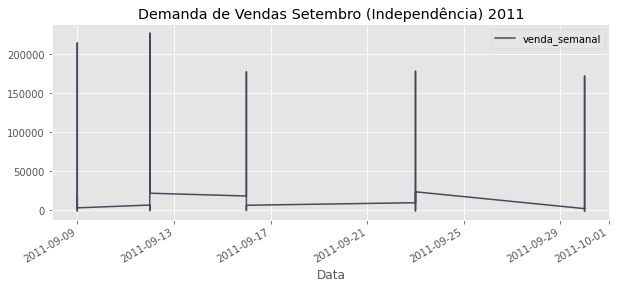

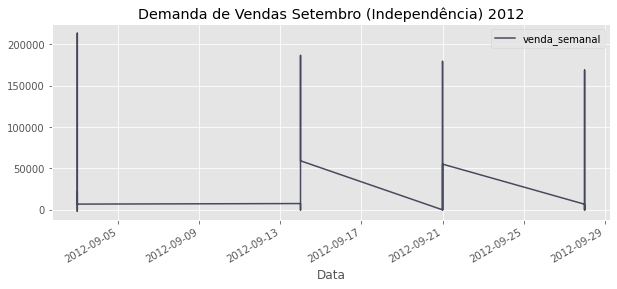

In [ ]:
#Demanda de vendas evento de Independência em cada ano
df_vendas_demanda.loc["2010-09-01":"2010-10-01"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas Setembro (Independência) 2010", c=dark_blue, alpha=0.75,
)

df_vendas_demanda.loc["2011-09-01":"2011-10-01"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas Setembro (Independência) 2011", c=dark_blue, alpha=0.75,
)

df_vendas_demanda.loc["2012-09-01":"2012-10-01"].plot(
    y="venda_semanal", figsize=(10,4), title="Demanda de Vendas Setembro (Independência) 2012", c=dark_blue, alpha=0.75,
)

### Análise dos Eventos

In [ ]:
df_vendas.semana_de_evento.value_counts()

False    391909
True      29661
Name: semana_de_evento, dtype: int64

In [ ]:
#média e mediana
df_vendas.groupby('semana_de_evento')['venda_semanal'].mean(), df_vendas.groupby('semana_de_evento')['venda_semanal'].median()

(semana_de_evento
 False    15901.445069
 True     17035.823187
 Name: venda_semanal, dtype: float64, semana_de_evento
 False    7589.95
 True     7947.74
 Name: venda_semanal, dtype: float64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  del sys.path[0]


Text(0.5, 1.0, 'Semanal')

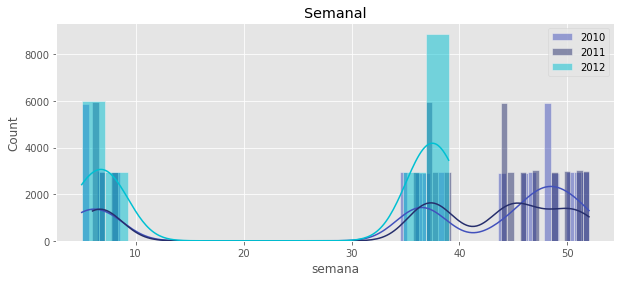

In [ ]:
#Demanda Semanal de Vendas Durante os Eventos (por ano)
df_demanda_eventos = df_vendas_demanda[df_vendas_demanda["meses_eventos"]==1].copy()

ax = sns.histplot(
    df_demanda_eventos.loc["2010-02-01":"2010-12-31"]["semana"],
    label="2010", color=light_blue, kde=True,
)
sns.histplot(
      df_demanda_eventos.loc["2011-01-01":"2011-12-31"]["semana"],
      label="2011", color=blue, ax=ax, kde=True,
)
sns.histplot(
      df_demanda_eventos.loc["2012-01-01":"2012-10-31"]["semana"],
      label="2012", color=teal, ax=ax, kde=True,
)
ax.legend()
ax.set_title("Semanal")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  del sys.path[0]


Text(0.5, 1.0, 'Mensal')

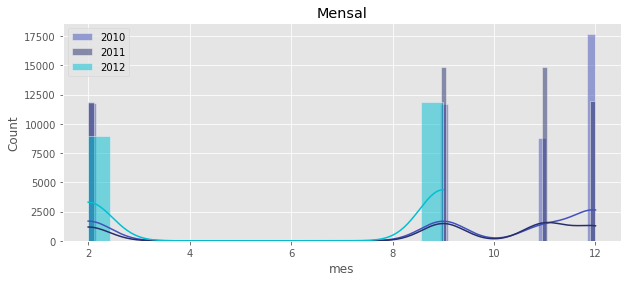

In [ ]:
#Demanda Mensal de Vendas Durante os Eventos (por ano)
df_demanda_eventos = df_vendas_demanda[df_vendas_demanda["meses_eventos"]==1].copy()

ax = sns.histplot(
    df_demanda_eventos.loc["2010-02-01":"2010-12-31"]["mes"],
    label="2010", color=light_blue, kde=True,
)
sns.histplot(
      df_demanda_eventos.loc["2011-01-01":"2011-12-31"]["mes"],
      label="2011", color=blue, ax=ax, kde=True,
)
sns.histplot(
      df_demanda_eventos.loc["2012-01-01":"2012-10-31"]["mes"],
      label="2012", color=teal, ax=ax, kde=True,
)
ax.legend()
ax.set_title("Mensal")

## Lojas x Vendas

### Melhor mês

In [ ]:
def get_melhor_mes(loja):
  df_loja = df_vendas[df_vendas['loja']==loja]
  ind = df_loja['venda_semanal'].idxmax()
  return df_loja['data'].dt.month[ind]

In [ ]:
def get_media_venda_melhor_mes(loja):
  df_loja = df_vendas[df_vendas['loja']==loja]
  ind = df_loja['venda_semanal'].idxmax()
  mes = df_loja['data'].dt.month[ind]
  venda_mes_media =  df_loja[df_loja['data'].dt.month==mes]['venda_semanal'].mean()
  return venda_mes_media

In [ ]:
df_lojas['melhor_mes'] = df_lojas.loja.apply(lambda x: get_melhor_mes(x))
df_lojas['media_venda_melhor_mes'] = df_lojas.loja.apply(lambda x: get_media_venda_melhor_mes(x))

In [ ]:
df_lojas.head()

,loja,tipo_de_loja,tamanho,melhor_mes,media_venda_melhor_mes,media_vendas,max_vendas,min_vendas,melhor_departamento,melhor_semana
0,1,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.00,72,47
1,2,A,130.520645,11,29297.481662,26898.070031,285353.53,-1098.00,72,47
2,3,B,24.123871,5,6306.361946,6373.033983,155897.94,-1008.96,38,17
3,4,A,132.814839,11,31735.961157,29161.210415,385051.04,-898.00,72,47
4,5,B,22.500000,11,5514.360123,5053.415813,93517.72,-101.26,72,47


In [ ]:
df_lojas['melhor_mes'].value_counts()

11    36
5      2
12     2
4      2
7      2
10     1
Name: melhor_mes, dtype: int64

### Melhor departamento

In [ ]:
def get_medias_vendas(loja):
  return df_vendas[df_vendas['loja']==loja]['venda_semanal'].mean()

In [ ]:
df_lojas['media_vendas'] = df_lojas.loja.apply(lambda x: get_medias_vendas(x))

In [ ]:
def get_max_vendas(loja):
  return df_vendas[df_vendas['loja']==loja]['venda_semanal'].max()

def get_min_vendas(loja):
  return df_vendas[df_vendas['loja']==loja]['venda_semanal'].min()

In [ ]:
df_lojas['max_vendas'] = df_lojas.loja.apply(lambda x: get_max_vendas(x))
df_lojas['min_vendas'] = df_lojas.loja.apply(lambda x: get_min_vendas(x))

In [ ]:
def get_melhor_departamento(loja):
  df_loja = df_vendas[df_vendas['loja']==loja]
  ind = df_loja['venda_semanal'].idxmax()
  return df_loja.departamento[ind]

In [ ]:
df_lojas['melhor_departamento'] = df_lojas.loja.apply(lambda x: get_melhor_departamento(x))

In [ ]:
df_lojas['melhor_departamento'].value_counts()

72    35
38     5
92     2
7      1
93     1
94     1
Name: melhor_departamento, dtype: int64

### Melhor semana

In [ ]:
def get_melhor_semana(loja):
  df_loja = df_vendas[df_vendas['loja']==loja]
  ind = df_loja['venda_semanal'].idxmax()
  return df_loja['data'].dt.week[ind]

In [ ]:
df_lojas['melhor_semana'] = df_lojas.loja.apply(lambda x:get_melhor_semana(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [ ]:
df_lojas['melhor_semana'].value_counts()

47    35
51     2
17     1
16     1
19     1
15     1
26     1
29     1
45     1
43     1
Name: melhor_semana, dtype: int64

### Heatmap

In [ ]:
df_loja_vendas = df_vendas.merge(df_lojas, on='loja')
df_loja_vendas.set_index('data', drop=True, inplace=True)

df_loja_vendas_outras = df_loja_vendas.merge(df_caracteristicas,on=['data','loja'])

In [ ]:
df_loja_vendas_outras.head()

,data,loja,departamento,venda_semanal,semana_de_evento,tipo_de_loja,tamanho,melhor_mes,media_venda_melhor_mes,media_vendas,max_vendas,min_vendas,melhor_departamento,melhor_semana,preco_combustivel,IPC,taxa_desemprego,evento
0,2010-02-19,1,1,41595.55,False,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,2.514,211.289143,8.106,False
1,2010-02-19,1,2,47928.89,False,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,2.514,211.289143,8.106,False
2,2010-02-19,1,3,11523.47,False,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,2.514,211.289143,8.106,False
3,2010-02-19,1,4,36826.95,False,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,2.514,211.289143,8.106,False
4,2010-02-19,1,5,26468.27,False,A,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,2.514,211.289143,8.106,False


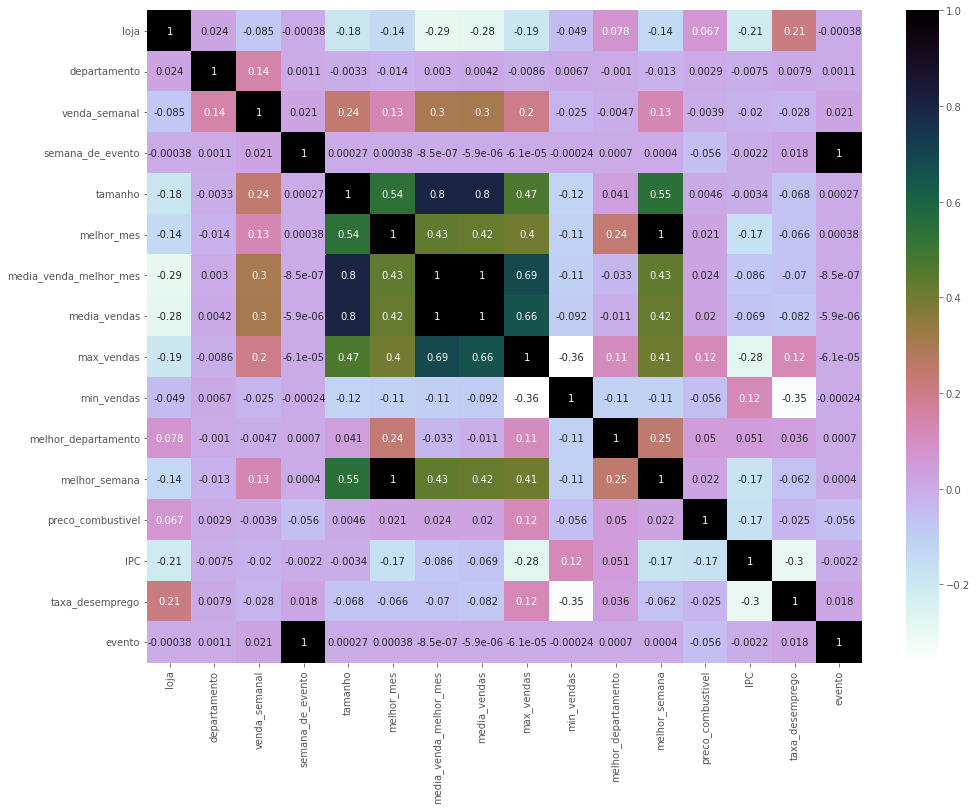

In [ ]:
plt.figure(figsize=(16,12)) 
sns.heatmap(df_loja_vendas_outras.corr(),annot=True,cmap='cubehelix_r')

plt.show()

## Lojas x Características x Vendas

Juntando tabelas

In [ ]:
# Juntando Tabelas de Lojas e Vendas
lv_db = df_vendas.merge(df_lojas, on='loja')
lv_db.set_index('data', drop=True, inplace=True)

# Juntando Tabelas de Lojas+Vendas e Outros Dados (Ignorando as tabelas de evento duplicadas)
lvo_db = lv_db.merge(df_caracteristicas,on=['data','loja']).drop('semana_de_evento', axis=1)

Adicionando Index Temporal

In [ ]:
# Passando a coluna de data para o index
lvo_db.set_index('data', drop=True, inplace=True)

# Separando datas em variáveis (Semana do ano, mes, trimestre, ano)
lvo_db['semana'] = lvo_db.index.weekofyear
lvo_db['mes'] = lvo_db.index.month
lvo_db['trimestre'] = lvo_db.index.quarter
lvo_db['ano'] = lvo_db.index.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


Adicionando Variáveis Temporais

In [ ]:
# Separando datas em variáveis (Semana do ano, mes, trimestre, ano)
lvo_db['semana'] = lvo_db.index.weekofyear
lvo_db['mes'] = lvo_db.index.month
lvo_db['trimestre'] = lvo_db.index.quarter
lvo_db['ano'] = lvo_db.index.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


Transformando Bools em Ints

In [ ]:
# Transformando coluna "Evento" para int (0 false, 1 true)
lvo_db['evento'] = lvo_db['evento'].astype(int)

One Hot Encoding

In [ ]:
# Aplicando One Hot Encoding na variável de tipo de loja (Pegando dummies)
lvo_db = pd.get_dummies(lvo_db,columns=['tipo_de_loja'])

Visualizando

In [ ]:
lvo_db

,loja,departamento,venda_semanal,tamanho,melhor_mes,media_venda_melhor_mes,media_vendas,max_vendas,min_vendas,melhor_departamento,...,IPC,taxa_desemprego,evento,semana,mes,trimestre,ano,tipo_de_loja_A,tipo_de_loja_B,tipo_de_loja_C
data,,,,,,,,,,,,,,,,,,,,,
2010-02-19,1,1,41595.55,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,...,211.289143,8.106,0,7,2,1,2010,1,0,0
2010-02-19,1,2,47928.89,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,...,211.289143,8.106,0,7,2,1,2010,1,0,0
2010-02-19,1,3,11523.47,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,...,211.289143,8.106,0,7,2,1,2010,1,0,0
2010-02-19,1,4,36826.95,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,...,211.289143,8.106,0,7,2,1,2010,1,0,0
2010-02-19,1,5,26468.27,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,...,211.289143,8.106,0,7,2,1,2010,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,45,93,2487.80,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,...,192.308899,8.667,0,43,10,4,2012,0,1,0
2012-10-26,45,94,5203.31,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,...,192.308899,8.667,0,43,10,4,2012,0,1,0
2012-10-26,45,95,56017.47,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,...,192.308899,8.667,0,43,10,4,2012,0,1,0


### Qual a variável alvo?

In [ ]:
ni_lvo = lvo_db.reset_index(level=0)
X = ni_lvo.loc[:,ni_lvo.columns != 'venda_semanal'].drop('data',axis=1)
y = ni_lvo[['venda_semanal']]

In [ ]:
X

,loja,departamento,tamanho,melhor_mes,media_venda_melhor_mes,media_vendas,max_vendas,min_vendas,melhor_departamento,melhor_semana,...,IPC,taxa_desemprego,evento,semana,mes,trimestre,ano,tipo_de_loja_A,tipo_de_loja_B,tipo_de_loja_C
0,1,1,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,...,211.289143,8.106,0,7,2,1,2010,1,0,0
1,1,2,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,...,211.289143,8.106,0,7,2,1,2010,1,0,0
2,1,3,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,...,211.289143,8.106,0,7,2,1,2010,1,0,0
3,1,4,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,...,211.289143,8.106,0,7,2,1,2010,1,0,0
4,1,5,97.622581,11,23056.417935,21710.543621,203670.47,-863.0,72,47,...,211.289143,8.106,0,7,2,1,2010,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282979,45,93,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,47,...,192.308899,8.667,0,43,10,4,2012,0,1,0
282980,45,94,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,47,...,192.308899,8.667,0,43,10,4,2012,0,1,0
282981,45,95,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,47,...,192.308899,8.667,0,43,10,4,2012,0,1,0
282982,45,97,76.271613,11,12651.964548,11662.897315,240758.86,-1750.0,72,47,...,192.308899,8.667,0,43,10,4,2012,0,1,0


In [ ]:
y

,venda_semanal
0,41595.55
1,47928.89
2,11523.47
3,36826.95
4,26468.27
...,...
282979,2487.80
282980,5203.31
282981,56017.47
282982,6817.48


<i>Insight: A nossa variável alvo é venda_semanal</i>

### Como as vendas semanais se comportam em diferentes intervalos de tempo (Mes, trimestre)?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


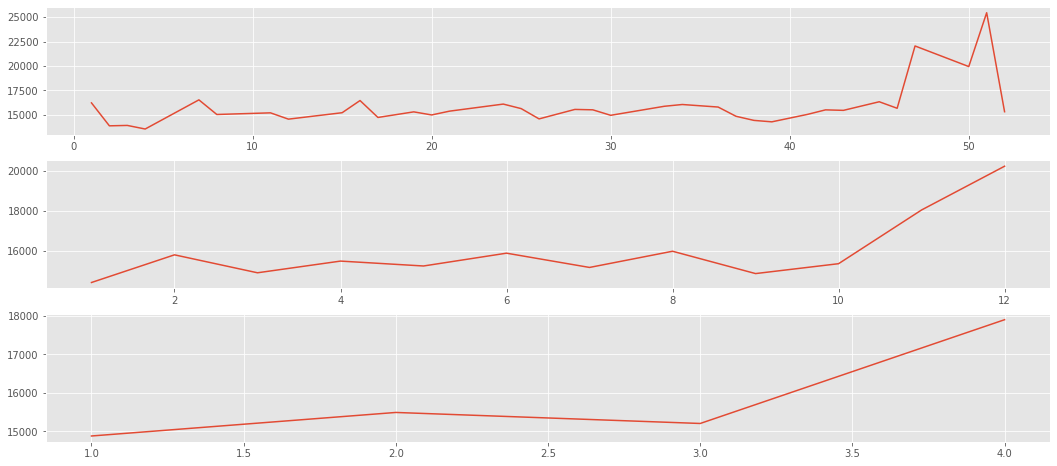

In [ ]:
data_mean_lvo = lvo_db.groupby('data').mean()['2011']
month_mean_lvo = lvo_db['2011'].groupby('mes').mean()
tri_mean_lvo = lvo_db['2011'].groupby('trimestre').mean()

fig, axs = plt.subplots(3,figsize=(18,8))

axs[0].plot(data_mean_lvo['semana'],data_mean_lvo['venda_semanal'])
axs[1].plot(month_mean_lvo['venda_semanal'])
axs[2].plot(tri_mean_lvo['venda_semanal'])

<i>Insight 3: É possível ver que a venda semanal não se distância muito da venda mensal, mas que ambas são bem distântes da trimestral.</i>

### Existe Sazonalidade em períodos diferentes? (Mês, 2 meses, 6 meses...)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """


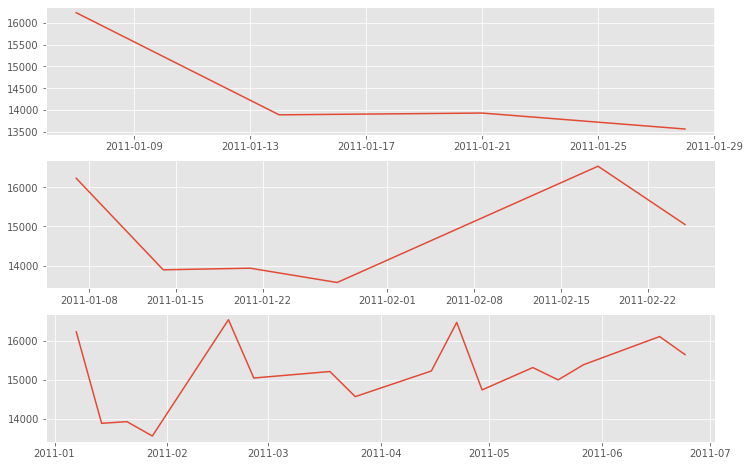

In [ ]:
# Usando 2011 como ano base
df_2011 = lvo_db.loc['2011',['venda_semanal']].groupby('data').mean()

# Separar dados em diferentes intervalos
df_2011_m = df_2011['2011-01']
df_2011_m2 = df_2011['2011-01':'2011-02']
df_2011_m6 = df_2011['2011-01':'2011-06']

# Criar subplots
fig, axs = plt.subplots(3,figsize=(12,8))

# Plotar cada grafico
axs[0].plot(df_2011_m)
axs[1].plot(df_2011_m2)
axs[2].plot(df_2011_m6)

<i>Insight 4: A sazonalidade é apenas anual.</i>

### Distribuição de Probabilidade de Venda Semanal

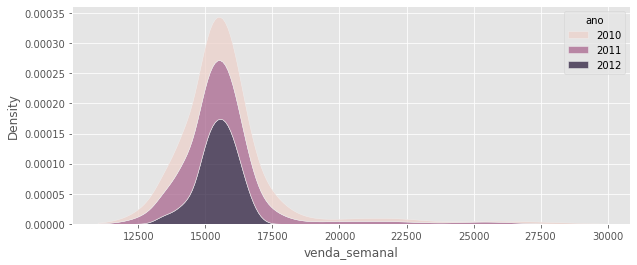

In [ ]:
# Função de Densidade de Probabilidade/ Kernel Distribution Estimation
# Plotar várias linhas, cada uma de uma cor e cada uma representando um ano, mostrando a probabilidade da venda semanal naquele ano ter aquele valor
df_vs = lvo_db[['semana','venda_semanal','ano']].groupby(['semana','ano']).mean().reset_index()

# Separar dados por ano
#df_vs_yr = [df_vs['2010'],df_vs['2011'],df_vs['2012']]

# Plotar KDE da venda_semanal para cada ano
sns.kdeplot(data=df_vs, x='venda_semanal',hue='ano',multiple='stack')

<i>Insight 4: Durante os anos, a chance dos valores estarem entre 12500 e 20000 diminuiu. O valor  que tem mais chance de acontecer durante os anos é próximo de 16000.</i>

### Os ganhos por departamento de lojas diferentes são parecidos?

                   venda_semanal     ano
departamento loja                       
1            4        3504908.47  193057
2            4        8989785.95  193057
3            4        1863700.89  193057
4            4        5407833.13  193057
5            4        4475201.69  193057
6            4         840470.67  193057
7            4        5075947.49  193057
8            4        5990421.58  193057
9            4        3322626.69  193057
10           4        3568218.29  193057
11           4        2546558.88  193057
12           4         765820.27  193057
13           4        6626281.97  193057
14           4        2800899.20  193057
16           4        1975269.32  193057
17           4        1525217.26  193057
18           4        1080753.98  170940
19           4         288014.85  193057
20           4         853316.11  193057
21           4         844622.82  193057
22           4        1675246.02  193057
23           4        4456682.71  193057
24           4  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

                   venda_semanal     ano
departamento loja                       
1            13       4509472.67  193057
2            13       7301333.19  193057
3            13       2560254.07  193057
4            13       4048877.01  193057
5            13       5479711.72  193057
6            13        780447.09  193057
7            13       5792371.86  193057
8            13       3438618.80  193057
9            13       3901044.09  193057
10           13       2833134.70  193057
11           13       2020218.04  193057
12           13        755574.66  193057
13           13       4533429.56  193057
14           13       2584215.40  193057
16           13       2102815.09  193057
17           13       1696716.77  193057
18           13       1327803.94  156861
19           13        382761.88  193057
20           13        826236.62  193057
21           13        870813.23  193057
22           13       1586736.24  193057
23           13       2940211.16  193057
24           13 

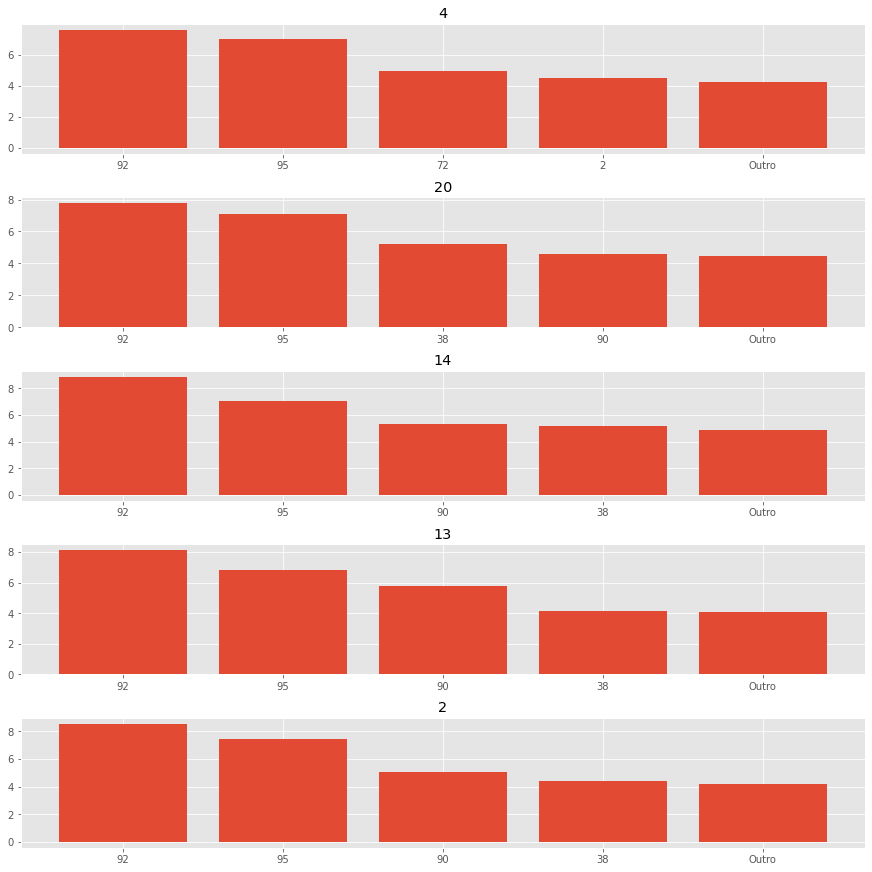

In [ ]:
# Pegar média semanal de dep/loja
df_dp_lj = lvo_db[['loja','departamento','venda_semanal','ano']]
# Escolher as 5 lojas com maior ganho semanal médio
mean_loja = df_dp_lj.groupby('loja').mean().sort_values('venda_semanal',ascending=False).reset_index().iloc[0:5]['loja'].values
df_dp_lj = df_dp_lj[df_dp_lj.loja.isin(mean_loja)]
# Transformar em porcentagem (Considerando a soma de todos os departamentos daquela loja como 100%)
perc_dep_lj = []
fig, axs = plt.subplots(len(mean_loja),figsize=(12,12),constrained_layout=True)
for i,lj in enumerate(mean_loja):
  df_loja_lj = df_dp_lj[df_dp_lj.loja == lj]
  hund_perc = df_loja_lj['venda_semanal'].sum()
  df_perc_dep = df_loja_lj.groupby(['departamento','loja']).sum()
  print(df_perc_dep)
  df_perc_dep['perc'] = (df_perc_dep['venda_semanal'] / hund_perc) * 100
  df_perc_dep = df_perc_dep.sort_values('perc',ascending=False).reset_index()
# Para cada loja, escolher os departamentos com porcentagem igual ou maior do que 20. Os com menos serão somados até terem 20% ou mais e serão colocados em um grupo.
  df_perc_dep['dep'] = 'A'
  df_perc_dep.iloc[:4]['dep'] = df_perc_dep.iloc[:4].departamento.astype(str)
  df_perc_dep.iloc[4:]['dep'] = 'Outro'  
  perc_dep_lj.append(df_perc_dep)
# Plotar barras com x sendo dep por loja e y sendo porcentagem de ganho
  axs[i].bar(x=df_perc_dep['dep'],height=df_perc_dep['perc'])
  axs[i].set_title(lj)
  print(df_perc_dep)

<i>Insight 5: Comm pouca variação, os departamentos 92,95,90 e 38 são os que geram mais lucro dentre as diferentes lojas.</i>

### Quais as lojas que mais vendem?

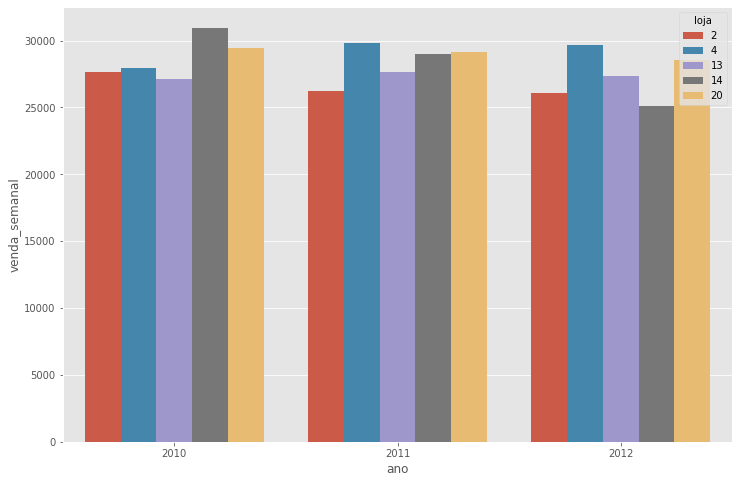

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_dp_lj.groupby(['loja','ano']).mean().reset_index(),x='ano',y='venda_semanal',hue='loja')

<i>Insight 6: As lojas 2,3 e 20 se mantém estaveis durante os anos. A loja 4 está vendendo mais a cada ano e a loja 14 está vendendo menos.</i>

### Quais os departamentos que mais vendem?

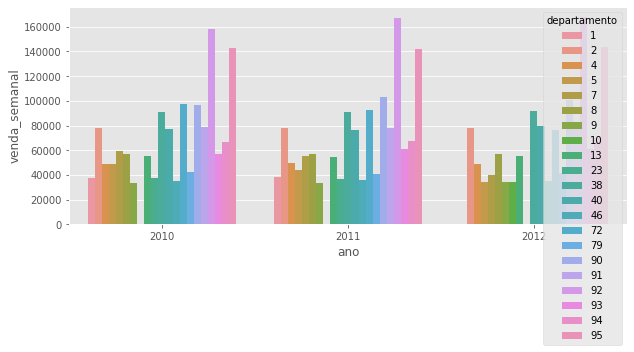

In [ ]:
dp_lj_m = df_dp_lj.groupby(['departamento','ano']).mean().reset_index()
sns.barplot(data=dp_lj_m[dp_lj_m.venda_semanal > dp_lj_m.venda_semanal.quantile(0.75)],x='ano',y='venda_semanal',hue='departamento')

<i>Apenas nos confirma que os departamentos 92 e 95 são os que mais vendem.</i>

### Quais são as variáveis que mais se influenciam?

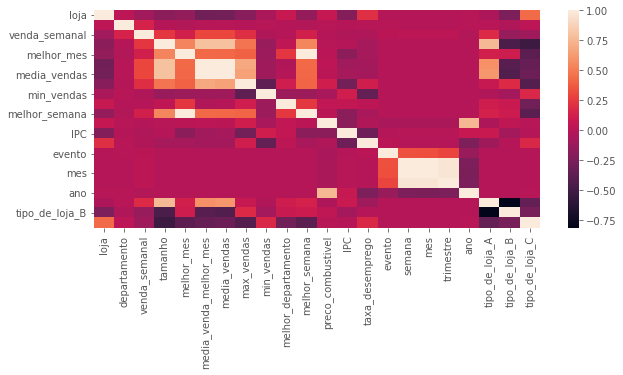

In [ ]:
sns.heatmap(ni_lvo.corr())

<i>Insight 7:Os tipos de loja, tamanho, departamento e numero de loja são as que mais interferem</i>

## Lags interferem?
Lembrando que lags, nesse caso, devem ser separados por lojas e por departamentos, ou por média de loja.

In [ ]:
df_dp_lj = lvo_db[['loja','departamento','venda_semanal','ano']]
# Separar Lojas

df_dp_lj.sort_values(['loja','data'], inplace=True)
df_lj_lag = df_dp_lj.copy()
df_lj_lag['lag'] = df_dp_lj['venda_semanal'].shift()
df_lj_lag.loc[(df_lj_lag.index == '2010-02-05') & (df_lj_lag.departamento == 1),'lag'] = 0
print(df_lj_lag.drop(['loja','departamento','ano'],axis=1).corr())
# Separar Média de Loja
df_lj_lag_m = df_dp_lj.groupby(['loja','data']).mean()
df_lj_lag_m['lag'] = df_lj_lag_m.venda_semanal.shift()
df_lj_lag_m.loc['2010-02-05','lag'] = 0
print(df_lj_lag.drop(['departamento','ano'],axis=1).corr())

               venda_semanal       lag
venda_semanal       1.000000  0.394838
lag                 0.394838  1.000000
                   loja  venda_semanal       lag
loja           1.000000      -0.084842 -0.084844
venda_semanal -0.084842       1.000000  0.394838
lag           -0.084844       0.394838  1.000000


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


<i>Insight 8: Existe SIM uma interferência decente dos valores anteriores nos valores da semana atual</i>

## Quais são os efeitos dos indices de Desemprego e IPC nas vendas semanais?

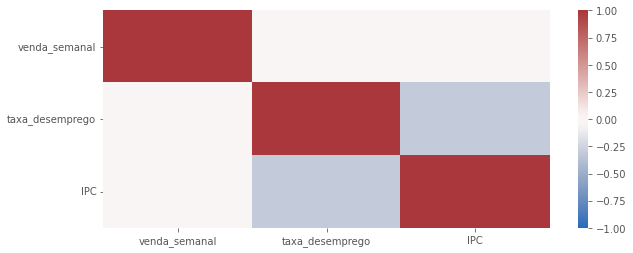

In [ ]:
sns.heatmap(lvo_db[['venda_semanal','taxa_desemprego','IPC']].corr(), cmap='vlag',vmax=1, vmin=-1)

<i>Insight 9: Taxa de desemprego e IPC não interferem o suficiente para serem usados.</i>

# Engenharia de Variáveis

In [ ]:
def criaFeatures(df):
  df['temp'] = df.index.to_pydatetime()
  df['Quarter'] = df['temp'].apply(lambda t: t.quarter)
  df['rolling_mean_1'] = df['venda_semanal'].rolling(window=96).mean()
  df['rolling_mean_1'] = df['venda_semanal'].rolling(window=672).mean()
  df['rolling_mean_1'] = df['venda_semanal'].rolling(window=1344).mean()
  df['rolling_mean_1'] = df['venda_semanal'].rolling(window=2880).mean()
  df = df.drop(columns=["temp"], inplace=True)

criaFeatures(df_vendas_demanda)

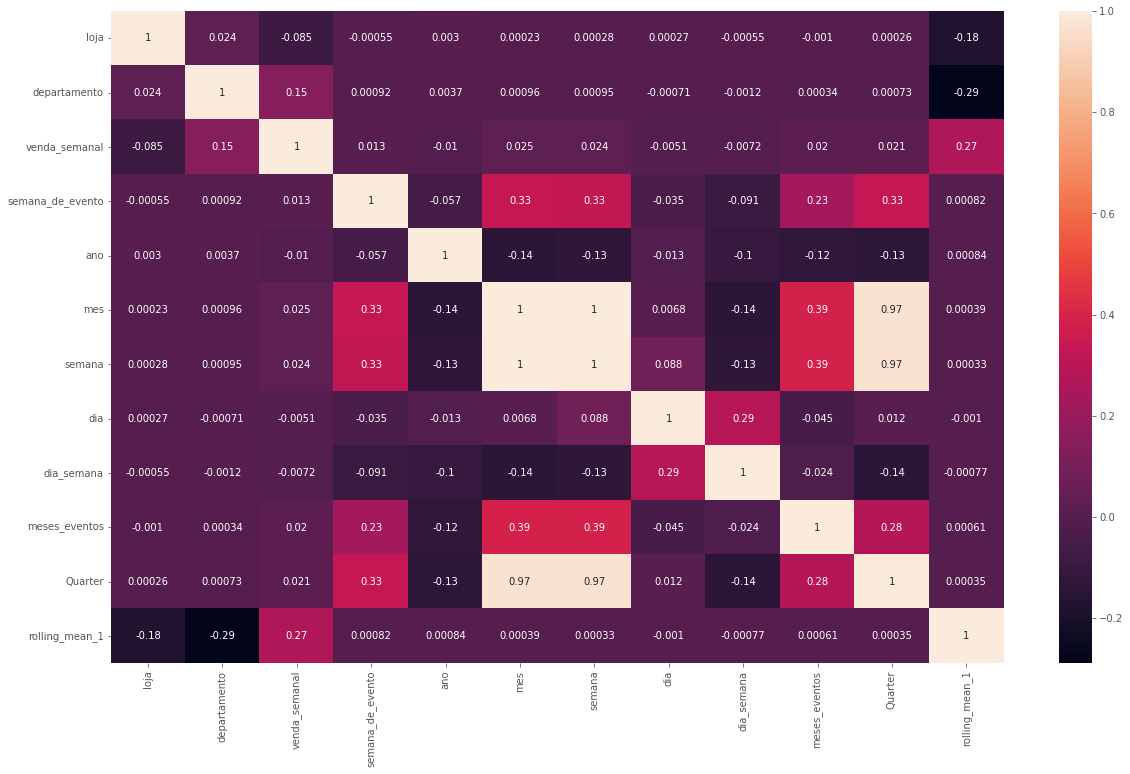

In [ ]:
#correlação
plt.figure(figsize=(20,12))
corr = df_vendas_demanda.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Modelo

In [ ]:
cv = TimeSeriesSplit(n_splits=10)

df_vendas = pd.read_csv(path+'vendas.csv')
df_vendas.data = pd.to_datetime(df_vendas.data, dayfirst=True)
df_vendas['semana_de_evento'] = df_vendas['semana_de_evento'].astype('int')
df_vendas['semana'] = df_vendas.data.dt.week
df_vendas = pd.concat([df_vendas.drop("loja", axis=1), pd.get_dummies(df_vendas.loja, prefix='loja')], axis=1)
df_vendas = pd.concat([df_vendas.drop("departamento", axis=1), pd.get_dummies(df_vendas.departamento, prefix='departamento')], axis=1)
df_vendas_data = df_vendas.set_index('data')

y = df_vendas_data.venda_semanal.sort_index()
X = df_vendas_data.drop(columns=['venda_semanal']).sort_index()

# usamos a função train_test_split para criar os sets de treino e teste
# define o tamanho do set de teste. Pode ser um inteiro (número de observações) ou então uma fração, correspondendo à proporção treino/teste
# suffle = False significa que a separação obedecerá a sequencia da data
X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                          test_size = 0.35, 
                                                          shuffle = False)

print("Train set X", X_training.shape)
print("Train set y", y_training.shape)
print("Test set X", X_test.shape)
X_test_backup = X_test

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13688\1285278962.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_vendas['semana'] = df_vendas.data.dt.week


Train set X (274020, 128)
Train set y (274020,)
Test set X (147550, 128)


In [ ]:
X_training

,semana_de_evento,semana,loja_1,loja_2,loja_3,loja_4,loja_5,loja_6,loja_7,loja_8,...,departamento_90,departamento_91,departamento_92,departamento_93,departamento_94,departamento_95,departamento_96,departamento_97,departamento_98,departamento_99
data,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-18,0,46,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2011-11-18,0,46,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-11-18,0,46,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



 Best hyperparameters:
{'max_features': 4, 'n_estimators': 500}
Average Score on train set: 0.992 +/- 0.003
Average Score on validation set: 0.923 +/- 0.081


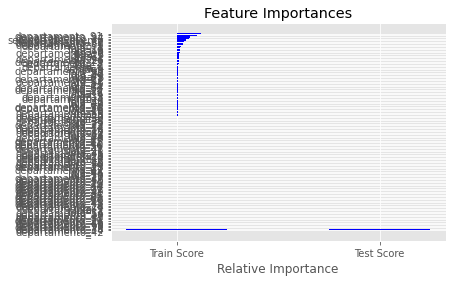

In [ ]:
params = {
    'n_estimators': [100, 500],
    'max_features': [2, 4]
}

# cria modelo
rf_model_cv_gs = RandomForestRegressor()

# objeto para grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, 
                           param_grid = params, 
                           return_train_score = True, 
                           cv = cv)

# treina modelo com Grid Search
grid_search.fit(X_training, y_training)

# imprime melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# resultados do cv
cv_results = pd.DataFrame(grid_search.cv_results_)

# print score médio nos sets de treino e teste
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# print score médio nos sets de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")  

# seta melhor opção baseada nos hiperparâmetros
# utiliza as melhores opções de hiperparâmetros encontrados
rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'])

# treina modelo com todos os dados de treino disponíveis e com os melhores hiperparâmetros encontrados
rf_model_cv_gs.fit(X_training, y_training)

features = df_vendas_data.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

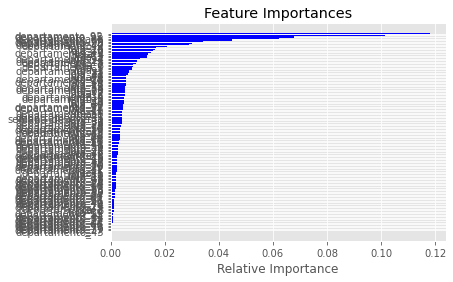

In [ ]:
features = X.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# cria modelo
rf_model_cv_gs = RandomForestRegressor()

rf_model_cv_gs.set_params(n_estimators = 500,
                           max_features = 5)

# treina modelo com todos os dados de treino disponíveis e com os melhores hiperparâmetros encontrados
rf_model_cv_gs.fit(X_training, y_training)

y_pred = rf_model_cv_gs.predict(X_test_backup)
print("MAE train:", mean_absolute_error(y_training, rf_model_cv_gs.predict(X_training)))
print("MAE test:", mean_absolute_error(y_test,y_pred)) 
print('R2:',r2_score(y_test, y_pred))


MAE train: 1010.3822204814109
MAE test: 2004.1096702735854
R2: 0.96684856779546


# Previsão

In [ ]:
df_vendas_2 = pd.read_csv(path+'vendas.csv')

lojas = df_vendas_2.loja.unique()

dep_loja = []

for loja in lojas:
  dep = df_vendas_2[df_vendas_2.loja==loja].departamento.unique()
  dep_loja.append([loja, dep])
    
df_vendas_2.data = pd.to_datetime(df_vendas.data, dayfirst=True)

df_vendas_2.data.max() + timedelta(days=7)

datas = pd.date_range(start ='2012-11-02', end ='2013-05-01', freq='W')   

datas_evento = pd.to_datetime(['2013-02-10', '2012-11-25', '2012-12-30'])

previsao = []
for c in dep_loja:
  loja = c[0]
  for dep in c[1]:
    for data in datas:
      if data in datas_evento: # carnaval OU black friday OU natal
        previsao.append([loja, dep, data, True])
      else:
        previsao.append([loja, dep, data, False])
        
df_previsao = pd.DataFrame(previsao, columns=['loja', 'departamento', 'data', 'semana_de_evento'])
df_previsao['semana'] = df_previsao.data.dt.week
df_previsao.to_csv('previsao.csv', index=False)

X = df_previsao.drop('data',axis=1)
X = pd.get_dummies(X, columns=['loja','departamento'])
y_pred = rf_model_cv_gs.predict(X)

pred = pd.DataFrame(y_pred)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13688\3739096085.py:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_previsao['semana'] = df_previsao.data.dt.week


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13688\537700007.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_vendas['semana'] = df_vendas.data.dt.week


<AxesSubplot:xlabel='data'>

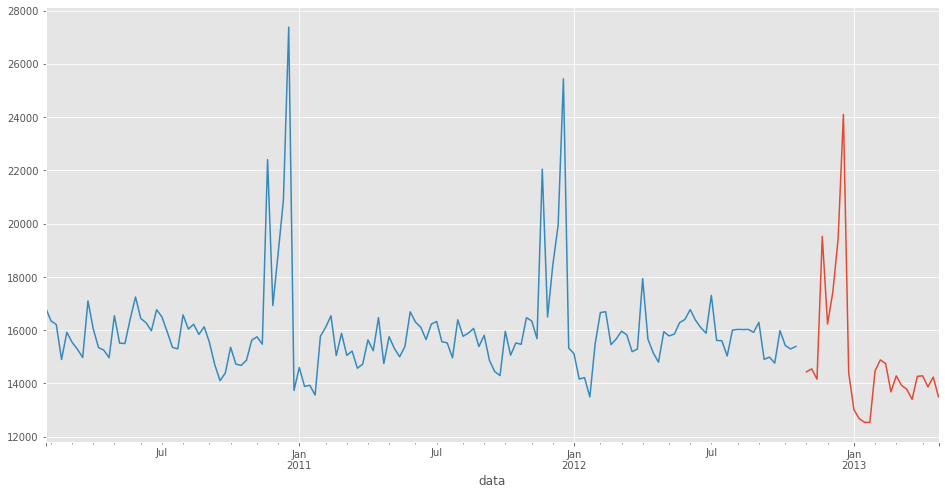

In [ ]:
df_vendas = pd.read_csv(path+'vendas.csv')
df_vendas.data = pd.to_datetime(df_vendas.data, dayfirst=True)
df_vendas['semana_de_evento'] = df_vendas['semana_de_evento'].astype('int')
df_vendas['semana'] = df_vendas.data.dt.week
df_vendas = pd.concat([df_vendas.drop("loja", axis=1), pd.get_dummies(df_vendas.loja, prefix='loja')], axis=1)
df_vendas = pd.concat([df_vendas.drop("departamento", axis=1), pd.get_dummies(df_vendas.departamento, prefix='departamento')], axis=1)
df_vendas_data = df_vendas.set_index('data')

y = df_vendas_data.venda_semanal.sort_index()
X = df_vendas_data.drop(columns=['venda_semanal']).sort_index()

pred = pd.DataFrame(y_pred,columns=['venda_semanal']).join(df_previsao)
m_data = pred.groupby('data').mean().sort_index(axis=0)['venda_semanal']
m_data.plot(kind='line')
y.groupby(y.index).mean().plot(kind='line',figsize=(16,8))